Working Jupyter Notebook for Brendan/Akash/Somenath

Project timeline - https://docs.google.com/spreadsheets/d/1iCDTWZP4ulb0T6hACZsppoKxb1SsO-42BvD9SKU07dE/edit?usp=sharing

Log book - https://actually-antelope-fc8.notion.site/Log-book-39441686ae984d20a07484e91e1e1b32

To do - https://actually-antelope-fc8.notion.site/To-do-list-811b5d4e7fd1420ba5fe07d5918fccda


Import modules (BioPython)

# Use BioPython to read fasta file


In [1]:
import os
import sys
import numpy as np
import matplotlib.pyplot as plt

import Bio
from Bio import SeqIO

In [2]:
input_file = "./gRNA_sequences/benchling_export.fasta" #gRNA sequences
targets = "./gRNA_sequences/targets.fasta"

In [3]:
#Read gRNA sequences using biopython fasta parser
records = list(SeqIO.parse(input_file, "fasta"))
records_targets = list(SeqIO.parse(targets, "fasta"))

In [4]:
#Rename gRNA sequences to use with MEME motif 
for i in range(len(records)):
  records[i].name = 'gRNA%s' %i
  records[i].id = 'gRNA%s' %i
out_handle = open("./gRNA_sequences/renamed_gRNA.fasta", "w")
SeqIO.write(records, out_handle, "fasta")
out_handle.close()
records[0]

SeqRecord(seq=Seq('cctgctggtggctccagttc'), id='gRNA0', name='gRNA0', description='gRNA DNA sequence 1', dbxrefs=[])

In [5]:
#Check that all gRNAs are of length 20
for i in range(len(records)):
  if len(records[i].seq) != 20:
    print("gRNA%s not length 20" % i )
for i in range(len(records_targets)):
  if len(records_targets[i].seq) != 60:
    print("target%s not length 60" % i )

In [6]:
records_targets[0].seq[16:], records[0].seq, records[1].seq

(Seq('ttttcctgctggtggctccagttcaggaacagtaaaccctgctc'),
 Seq('cctgctggtggctccagttc'),
 Seq('ctgctggtggctccagttca'))

# Use Blast to perform conservation analysis across HepB variants 

In [7]:
#Import packages for online blast
from Bio.Blast import NCBIWWW, NCBIXML #https://biopython.org/docs/1.75/api/Bio.Blast.NCBIWWW.html
#help(NCBIWWW.qblast)

In [8]:
def runBlast(seq, database = "nt", numbers = 6000):
    """returns numbers amount of results. Issues where if ask for too many results then XML output breaks and can't be parsed so reduce number if see issue"""
    #databases available - https://ncbi.github.io/blast-cloud/blastdb/available-blastdbs.html
    result_handle = NCBIWWW.qblast("blastn", database, seq, expect = 10000, descriptions = numbers, alignments = numbers, hitlist_size = numbers)
    return result_handle

In [9]:
def saveBlasttoXML(result_handle, file_location):
    with open(file_location, 'w') as save_file: 
      blast_results = result_handle.read() 
      save_file.write(blast_results)

In [ ]:
result_handle = runBlast(records[116].seq, numbers = 1000)

In [ ]:
file_location = "./Blast_conservation/gRNA116.xml"
saveBlasttoXML(result_handle, file_location)

In [ ]:
### To display blast output

#Set threshold E value below which a result will be printed
E_VALUE_THRESH = 100
count = 0
for record in NCBIXML.parse(open("./Blast_conservation/my_blast.xml")): 
    if record.alignments: 
      print("\n") 
      print("query: %s" % record.query[:100]) 
      for align in record.alignments: 
          for hsp in align.hsps: 
            count += 1
            if hsp.expect < E_VALUE_THRESH and count < 20: 
                print("match: %s " % align.title[:100])

print(count)



query: No definition line
match: gi|1854276100|gb|MT114173.1| Hepatitis B virus isolate 051, complete genome 
match: gi|1854276094|gb|MT114172.1| Hepatitis B virus isolate 197, complete genome 
match: gi|1854276089|gb|MT114171.1| Hepatitis B virus isolate 118, complete genome 
match: gi|1854276084|gb|MT114170.1| Hepatitis B virus isolate 076, complete genome 
match: gi|1854276079|gb|MT114169.1| Hepatitis B virus isolate 1745, complete genome 
match: gi|1850899703|gb|MN657318.1| Hepatitis B virus isolate XZDP10, complete genome 
match: gi|1850899695|gb|MN657317.1| Hepatitis B virus isolate XZ253, complete genome 
match: gi|1850899689|gb|MN657316.1| Hepatitis B virus isolate XZ241, complete genome 
match: gi|1850899681|gb|MN657315.1| Hepatitis B virus isolate XZ74, complete genome 
match: gi|1849794996|gb|MN683731.1| Hepatitis B virus isolate QH277, complete genome 
match: gi|1849794989|gb|MN683730.1| Hepatitis B virus isolate QH321, complete genome 
match: gi|1849794981|gb|MN683729.1|

In [16]:
count = 0
total_correct = 0
total_length = 0
for record in NCBIXML.parse(open("./Blast_conservation/gRNA124.xml")): 
  for align in record.alignments:
    if 'Hepatitis B' in align.title and 'isolate' in align.title:
      for hsp in align.hsps:
        if count == 1:
          print(hsp)
        #count total number of correct alignments
        total_correct += hsp.positives
        #count total length
        total_length += hsp.align_length
        count += 1
    else:
      pass
#print percentage conservation (how much the of the bases are correct)
print(count, total_correct/total_length)

Score 40 (37 bits), expectation 9.9e+00, alignment length 20
Query:       1 AGTTGGCTCCGAATGCAGGG 20
               ||||||||||||||||||||
Sbjct:    2959 AGTTGGCTCCGAATGCAGGG 2940
3546 0.9941915043417038


In [ ]:
conservation_scores = []

In [ ]:
#Check XML file for each blast run for each gRNA is parseable
for i in range(110, 118):
  file_location = "./Blast_conservation/gRNA%s.xml" % i
  #result_handle = runBlast(records[i].seq, numbers = 4000)
  #saveBlasttoXML(result_handle, file_location)
  total_length = 0
  print('gRNA%s' %i)
  try:
    for record in NCBIXML.parse(open(file_location)): 
      for align in record.alignments:
        if 'Hepatitis B' in align.title and 'isolate' in align.title:
          for hsp in align.hsps:
            total_length += hsp.align_length
    if total_length == 0:
      print("gRNA%s - fetching again, 0 results issue" % i)
      result_handle = runBlast(records[i].seq, numbers = 1500)
      saveBlasttoXML(result_handle, file_location)
      print("gRNA%s done" % i)
  except:
    print("gRNA%s - fetching again" % i)
    result_handle = runBlast(records[i].seq, numbers = 1500)
    saveBlasttoXML(result_handle, file_location)
    print("gRNA%s done" % i)


gRNA110
gRNA111
gRNA111 - fetching again
gRNA111 done
gRNA112
gRNA113
gRNA114
gRNA115
gRNA115 - fetching again
gRNA115 done
gRNA116
gRNA117


In [ ]:
#For each gRNA, compute conservation percentage
for i in range(127):
  file_location = "./Blast_conservation/gRNA%s.xml" % i
  count = 0
  total_correct = 0
  total_length = 0
  try:
    for record in NCBIXML.parse(open(file_location)): 
      for align in record.alignments:
        if 'Hepatitis B' in align.title and 'isolate' in align.title:
          for hsp in align.hsps:
            count += 1
            total_correct += hsp.positives
            total_length += hsp.align_length
        else:
          pass
    print("gRNA%s" % i)
    conservation_scores.append(total_correct/total_length)
  except:
    print("gRNA%s - rip didn\'t work" % i)
    conservation_scores.append(None)
conservation_scores

gRNA0
gRNA1
gRNA2
gRNA3
gRNA4
gRNA5
gRNA6
gRNA7
gRNA8
gRNA9
gRNA10
gRNA11
gRNA12
gRNA13
gRNA14
gRNA15
gRNA16
gRNA17
gRNA18
gRNA19
gRNA20
gRNA21
gRNA22
gRNA23
gRNA24
gRNA25
gRNA26
gRNA27
gRNA28
gRNA29
gRNA30
gRNA31
gRNA32
gRNA33
gRNA34
gRNA35
gRNA36
gRNA37
gRNA38
gRNA39
gRNA40
gRNA41
gRNA42
gRNA43
gRNA44
gRNA45
gRNA46
gRNA47
gRNA48
gRNA49
gRNA50
gRNA51
gRNA52
gRNA53
gRNA54
gRNA55
gRNA56
gRNA57
gRNA58
gRNA59
gRNA60
gRNA61
gRNA62
gRNA63
gRNA64
gRNA65
gRNA66
gRNA67
gRNA68
gRNA69
gRNA70
gRNA71
gRNA72
gRNA73
gRNA74
gRNA75
gRNA76
gRNA77
gRNA78
gRNA79
gRNA80
gRNA81
gRNA82
gRNA83
gRNA84
gRNA85
gRNA86
gRNA87
gRNA88
gRNA89
gRNA90
gRNA91
gRNA92
gRNA93
gRNA94
gRNA95
gRNA96
gRNA97
gRNA98
gRNA99
gRNA100
gRNA101
gRNA102
gRNA103
gRNA104
gRNA105
gRNA106
gRNA107
gRNA108
gRNA109
gRNA110
gRNA111
gRNA112
gRNA113
gRNA114
gRNA115
gRNA116
gRNA117
gRNA118
gRNA119
gRNA120
gRNA121
gRNA122
gRNA123
gRNA124
gRNA125
gRNA126


[0.99994720470934,
 0.9999506013166994,
 0.9770681069520655,
 0.9996688045185805,
 0.9996796739792945,
 0.9996782018362469,
 0.9813220897547736,
 0.9570718738094659,
 0.9737314430629936,
 0.9951004627340752,
 0.9998233230962519,
 0.9994982033889193,
 0.9931206860969066,
 0.9994626519869082,
 0.9772528823707611,
 0.98300578351561,
 0.9998255058150187,
 0.9916303459547807,
 0.9848469264549365,
 0.9996475553558369,
 0.9572104804218744,
 0.9992921732052167,
 0.9994869520604527,
 0.9795284282871807,
 0.9998092410644787,
 0.9996665759987365,
 0.9993162527164801,
 0.9602393628762395,
 0.960586554603164,
 0.9977927383572022,
 0.9957137161084529,
 0.9568586101447524,
 0.9568582641738054,
 0.9564095429576707,
 0.9561346133558393,
 0.9995221738385669,
 0.9993924612363854,
 0.9993573264781491,
 0.9994615112994351,
 0.9994256377629916,
 0.999037009254848,
 0.9774070839982737,
 0.9885990744636096,
 0.9876873809458079,
 0.9792853947445199,
 0.9755772646536413,
 0.9763183638813518,
 0.9853029506719724

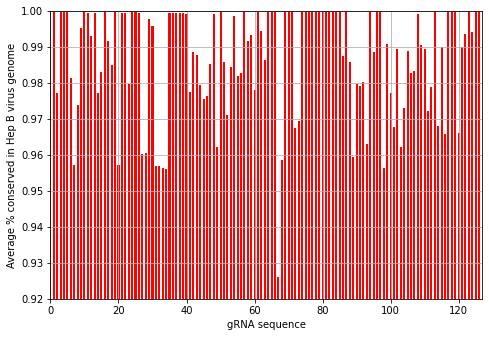

In [ ]:
#Move to Plotly
len(conservation_scores)
for i in range(len(conservation_scores)):
  if conservation_scores[i] == None:
    conservation_scores[i] = 0
x = np.arange(len(conservation_scores))
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.bar(x, conservation_scores, width = 0.6, color = 'r')
plt.xlabel('gRNA sequence');plt.ylabel('Average % conserved in Hep B virus genome');plt.grid()
plt.ylim(0.92, 1), plt.xlim(0, len(records))
plt.show()

In [ ]:
#Save to numpy
conservation_scores_np = np.asarray(conservation_scores)
np.save("./Blast_conservation/conservation_scores.npy",conservation_scores_np)

In [17]:
#Load from numpy conservation scores 
conservation_scores_np = np.load("./Blast_conservation/conservation_scores.npy", allow_pickle = True)
conservation_scores = list(conservation_scores_np)
conservation_scores[0:5]

[0.99994720470934,
 0.9999506013166994,
 0.9770681069520655,
 0.9996688045185805,
 0.9996796739792945]

# Hamming distance heatmap

In [ ]:
#Note this has nowm been replaced below as this doesn't include getting alignment correct
hamming_distances = []
for i in range(len(records)):
  hamming_distance_to_certain_grna = []
  for j in range(len(records)):
    count = 0
    for k in range(len(records[i].seq)):
      if records[i].seq[k] != records[j].seq[k]:
        count += 1
    hamming_distance_to_certain_grna.append(count)
  hamming_distances.append(hamming_distance_to_certain_grna)
hamming_distances = np.asarray(hamming_distances)

In [ ]:
hamming_distances.shape
for i in range(len(hamming_distances)):
  for j in range(len(hamming_distances[i])):
    if hamming_distances[i][j] < 8:
      if i!=j:
        print(i,j)

31 39
34 110
39 31
110 34


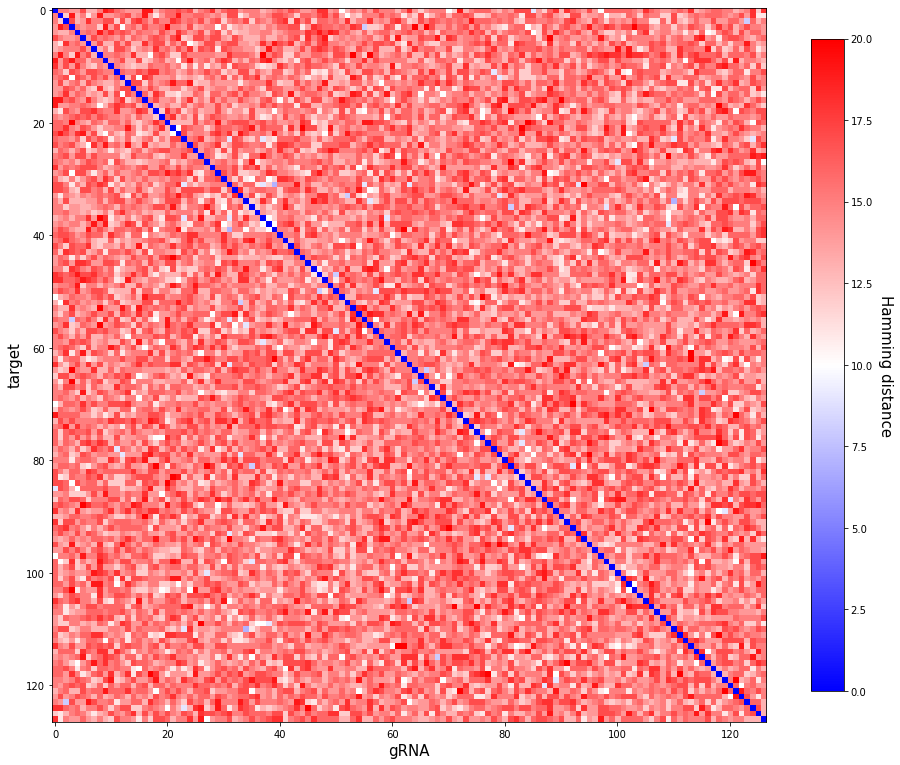

In [ ]:
plt.figure(figsize=(16, 16))
plt.imshow(hamming_distances, cmap='bwr', interpolation='nearest')
cbar = plt.colorbar(shrink = 0.75)
cbar.set_label('Hamming distance', rotation=270, fontsize = 15, labelpad = 20)

plt.xlabel('gRNA', fontsize = 15);plt.ylabel('target', fontsize = 15)
plt.show()

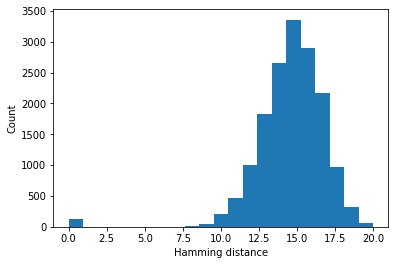

In [ ]:
hamming_distances_1d = hamming_distances.ravel()
plt.hist(hamming_distances_1d, bins = 21);plt.ylabel('Count');plt.xlabel('Hamming distance')
plt.show()

In [18]:
def align(grna, target):
    max = 0
    #For every starting position of target
    for k in range(len(target)):
      count = 0
      #For every nucleotide of the gRNA sequence 
      for l in range(min(len(target[k:]),len(grna))):
        if target[k+l] == grna[l]:
          count += 1
      if count >= max:
        max = count
        position = k
    return position

In [19]:
#Added some alignment algorithm
#For each target/gRNA pair, shuffle starting point of alignment and compute the hamming distance, take the minimum hamming distance
hamming_distances = []

#For every target
for i in range(len(records_targets)):
  hamming_distance_to_certain_grna = []
  #For every gRNA
  for j in range(len(records)):
    max = 0
    #For every starting position of target
    for k in range(len(records_targets[i].seq)):
      count = 0
      #For every nucleotide of the gRNA sequence 
      for l in range(min(len(records_targets[i].seq[k:]),len(records[j].seq))):
        if records_targets[i].seq[k+l] == records[j].seq[l]:
          count += 1
      if count >= max:
        max = count
        position = k
    hamming_distance_to_certain_grna.append(20-max)

  hamming_distances.append(hamming_distance_to_certain_grna)
hamming_distances = np.asarray(hamming_distances)

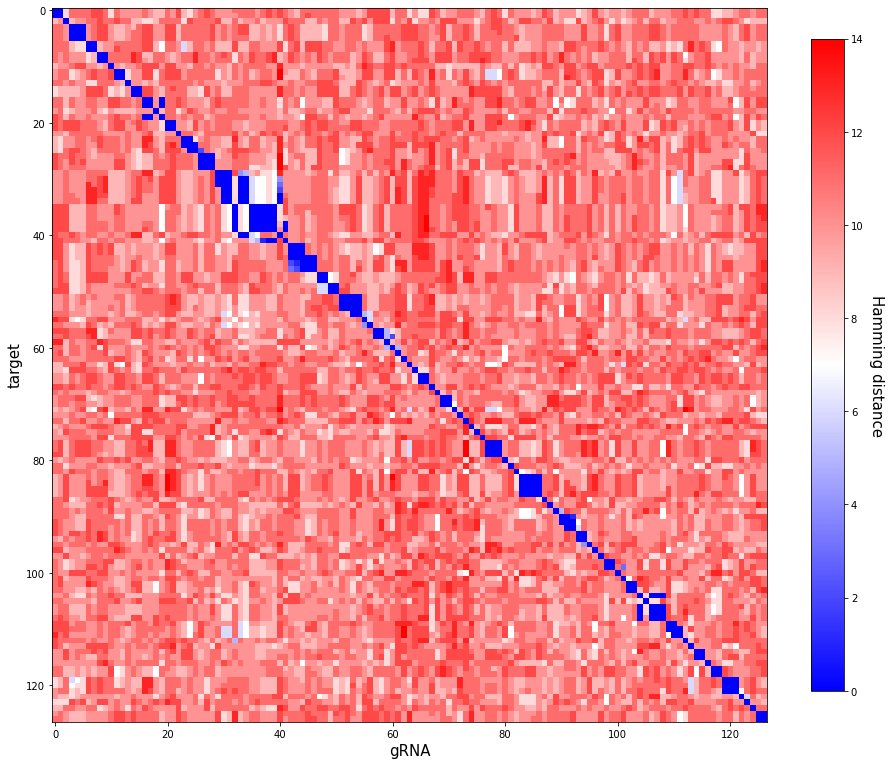

In [20]:
plt.figure(figsize=(16, 16))
plt.imshow(hamming_distances, cmap='bwr', interpolation='nearest')
cbar = plt.colorbar(shrink = 0.75)
cbar.set_label('Hamming distance', rotation=270, fontsize = 15, labelpad = 20)

plt.xlabel('gRNA', fontsize = 15);plt.ylabel('target', fontsize = 15)
plt.show()

In [21]:
import csv
count = 0
with open("./Outputs/hamming_distances.csv", 'w') as csv_file:
  csv_writer = csv.writer(csv_file, delimiter=',', quotechar='"', quoting=csv.QUOTE_MINIMAL)
  csv_writer.writerow(["Target", "gRNA", "Hamming distance"])
  for i in range(len(hamming_distances)):
    for j in range(len(hamming_distances[i])):
      if hamming_distances[i][j] < 6:
        if i!=j and i<j:
          print(i,j)
          count += 1
          csv_writer.writerow([i, j, hamming_distances[i][j]])
print(count)

0 1
3 4
3 5
4 5
6 7
8 9
11 12
14 15
16 17
16 19
17 19
20 21
23 24
24 25
25 26
26 27
26 28
27 28
29 30
29 31
29 33
29 34
30 31
30 33
30 34
30 40
31 33
31 34
31 40
32 33
32 34
32 40
33 34
33 40
34 40
35 36
35 37
35 38
35 39
36 37
36 38
36 39
37 38
37 39
38 39
38 41
39 41
42 43
42 44
43 44
44 45
44 46
45 46
47 48
49 50
51 52
51 53
51 54
52 53
52 54
53 54
54 55
57 58
57 59
58 59
58 60
60 61
65 66
69 70
77 78
77 79
78 79
83 84
83 85
83 86
84 85
84 86
85 86
89 90
90 91
90 92
91 92
93 94
98 99
99 101
102 103
104 106
104 107
104 108
106 107
106 108
107 108
109 110
110 111
114 115
117 118
119 120
119 121
120 121
125 126
100


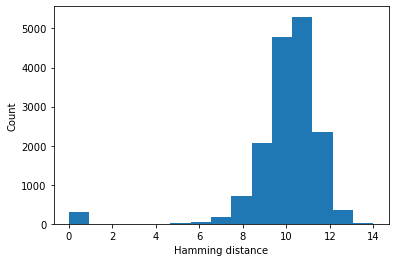

In [22]:
hamming_distances_1d = hamming_distances.ravel()
plt.hist(hamming_distances_1d, bins = 15);plt.ylabel('Count');plt.xlabel('Hamming distance')
plt.show()

# Import SS DNA data and process

In [10]:
ss_FAM = "./Echo_readings/ss_FAM.csv"
ss_ROX = "./Echo_readings/ss_ROX.csv"

ds_FAM = "./Echo_readings/ds_FAM.csv"
ds_ROX = "./Echo_readings/ds_ROX.csv"

In [11]:
import pandas as pd

ss_fam_data = pd.read_csv (ss_FAM)
ss_rox_data = pd.read_csv (ss_ROX)
ss_fam_data = ss_fam_data.iloc[:,1:]
ss_rox_data = ss_rox_data.iloc[:,1:]
ss_fam_data = ss_fam_data.rename(columns = {'Time [h]':'Sample'})
ss_rox_data = ss_rox_data.rename(columns = {'Time [h]':'Sample'})
ss_rox_data = pd.concat([ss_fam_data.iloc[:,0],ss_rox_data], axis=1)
ss_fam_data = ss_fam_data.set_index('Sample')
ss_rox_data = ss_rox_data.set_index('Sample')

ds_fam_data = pd.read_csv (ds_FAM)
ds_rox_data = pd.read_csv (ds_ROX)
ds_fam_data = ds_fam_data.iloc[:,1:]
ds_rox_data = ds_rox_data.iloc[:,1:]
ds_fam_data = ds_fam_data.rename(columns = {'Time [h]':'Sample'})
ds_rox_data = ds_rox_data.rename(columns = {'Time [h]':'Sample'})
ds_rox_data = pd.concat([ds_fam_data.iloc[:,0],ds_rox_data], axis=1)
ds_fam_data = ds_fam_data.set_index('Sample')
ds_rox_data = ds_rox_data.set_index('Sample')

In [12]:
times_fam = np.array([float(i) for i in list(ss_fam_data)])
times_rox = np.array([float(i) for i in list(ss_rox_data)])
t = times_fam
t

array([0.  , 0.08, 0.17, 0.25, 0.33, 0.42, 0.5 , 0.58, 0.67, 0.75, 0.83,
       0.92, 1.  , 1.08, 1.17, 1.25, 1.33, 1.42, 1.5 , 1.58, 1.67, 1.75,
       1.83, 1.92, 2.  , 2.08, 2.17, 2.25, 2.33, 2.42, 2.5 , 2.58, 2.67,
       2.75, 2.83, 2.92, 3.  , 3.08, 3.17, 3.25, 3.33, 3.42, 3.5 , 3.58,
       3.67, 3.75, 3.83, 3.92, 4.  , 4.08, 4.17, 4.25, 4.33, 4.42, 4.5 ,
       4.58, 4.67, 4.75, 4.83, 4.92])

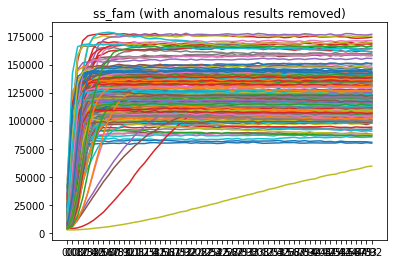

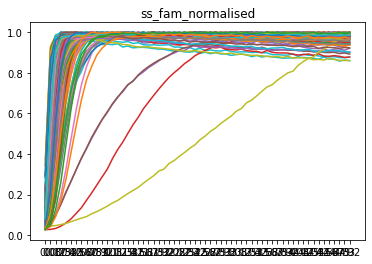

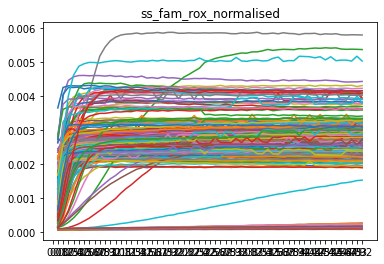

In [13]:
lower_limit = 20000
upper_limit = 185000
for i in range(len(ss_fam_data)):
  # plt.figure(i//3)
  if (i+1)%3 == 0 or np.max(ss_fam_data.iloc[i]) < lower_limit or np.max(ss_fam_data.iloc[i]) > upper_limit:
    continue
  plt.plot(ss_fam_data.iloc[i])
plt.title('ss_fam (with anomalous results removed)')
plt.show()

for i in range(len(ss_fam_data)):
  # plt.figure(i//3)
  if (i+1)%3 == 0 or np.max(ss_fam_data.iloc[i]) < lower_limit or np.max(ss_fam_data.iloc[i]) > upper_limit:
    continue
  plt.plot(ss_fam_data.iloc[i]/np.max(ss_fam_data.iloc[i]))
plt.title('ss_fam_normalised')
plt.show()

for i in range(len(ss_fam_data)):
  # plt.figure(i//3)
  if (i+1)%3 == 0 or np.max(ds_fam_data.iloc[i]) < upper_limit/np.mean(ss_rox_data.iloc[i]):
    continue
  plt.plot(ss_fam_data.iloc[i]/ss_rox_data.iloc[i]) # Check if this is how to apply normalisation
plt.title('ss_fam_rox_normalised')
plt.show()

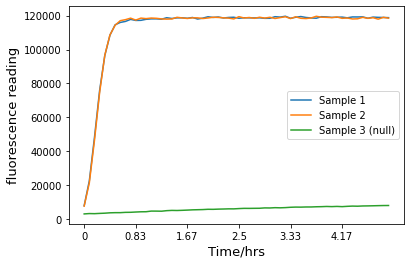

In [14]:
plt.figure(figsize=(6,4))
for i in range(3, 6):
  # plt.figure(i//3)
  plt.plot(ss_fam_data.iloc[i])
plt.xticks(np.arange(0, 60, 10));plt.xlabel('Time/hrs', fontsize=13);plt.ylabel('fluorescence reading', fontsize=13);plt.legend(['Sample 1', 'Sample 2', 'Sample 3 (null)'])
plt.show()

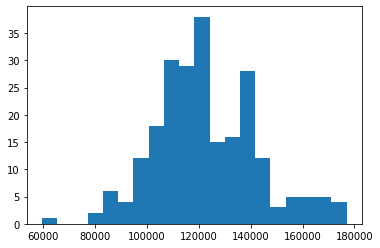

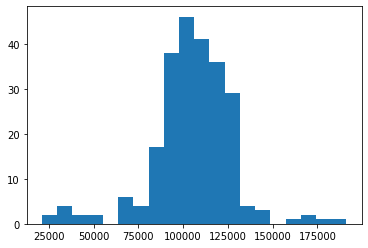

In [15]:
final_numbers = []
for i in range(len(ss_fam_data)):
    if (i+1) % 3 == 0 or np.max(ss_fam_data.iloc[i]) < lower_limit or np.max(ss_fam_data.iloc[i]) > upper_limit:
        continue
    else:
        final_numbers.append(ss_fam_data.iloc[i,-1])
plt.hist(final_numbers,bins = 20)
plt.show()

final_numbers = []
for i in range(len(ds_fam_data)):
    if (i+1) % 3 == 0 or np.max(ds_fam_data.iloc[i]) < lower_limit or np.max(ds_fam_data.iloc[i]) > 200000:
        continue
    else:
        final_numbers.append(ds_fam_data.iloc[i,-1])
plt.hist(final_numbers,bins = 20)
plt.show()

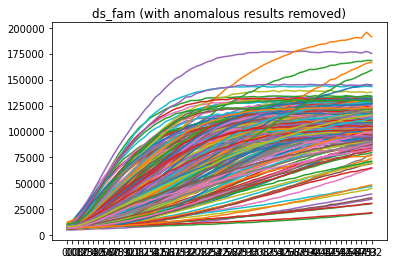

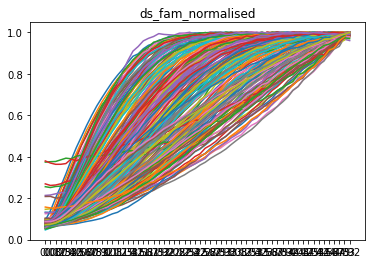

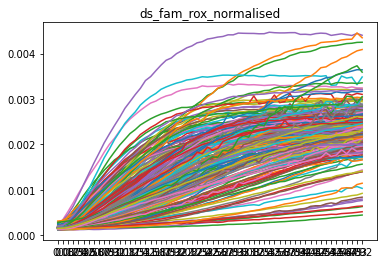

In [16]:
for i in range(len(ds_fam_data)):
  # plt.figure(i//3)
  if (i+1)%3 == 0 or np.max(ds_fam_data.iloc[i]) < lower_limit or np.max(ds_fam_data.iloc[i]) > 200000:
    continue
  plt.plot(ds_fam_data.iloc[i])
plt.title('ds_fam (with anomalous results removed)')
plt.show()

for i in range(len(ds_fam_data)):
  # plt.figure(i//3)
  if (i+1)%3 == 0 or np.max(ds_fam_data.iloc[i]) < lower_limit or np.max(ds_fam_data.iloc[i]) > 200000:
    continue
  plt.plot(ds_fam_data.iloc[i]/np.max(ds_fam_data.iloc[i]))
plt.title('ds_fam_normalised')
plt.show()

for i in range(len(ds_fam_data)):
  # plt.figure(i//3)
  if (i+1)%3 == 0 or np.max(ds_fam_data.iloc[i]) < lower_limit or np.max(ds_fam_data.iloc[i]) > 200000:
    continue
  plt.plot(ds_fam_data.iloc[i]/ds_rox_data.iloc[i]) 
plt.title('ds_fam_rox_normalised')
plt.show()

In [17]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

def exponential(t, a, b, c):
    return a * (1-np.exp(-b * t)) + c
def sigmoid(x, L ,x0, k, b):
    y = L / (1 + np.exp(-k*(x-x0)))+b
    return (y)

In [38]:
def calcKValues(data, func, minLimit = 20000, maxLimit = 185000, normalise = True, plot = False):
  if plot:
    fig, ax = plt.subplots((len(data))//3+1, 3, sharex='col', sharey='row', squeeze = False, figsize=(30,90))

  k_values = []
  errors = []
  r2 = []
  for i in range(len(data)):
    #print(i)
    y = data.iloc[i]

    if (i+1)%3 == 0 or np.max(y) < minLimit:
      k_values.append(0)
      continue
    
    # if np.max(y) > maxLimit:
    #   k_values.append(None)
    #   continue
      
    if normalise:
      y = y/np.max(y)

    try:
      if func == 'exponential':
        popt, pcov = curve_fit(exponential, t.astype('float64'), y.astype('float64'), p0 = [np.max(y), 1, np.min(y)], maxfev=20000)
        k_values.append(popt[1])
        errors.append(np.mean((y.astype('float64')-exponential(t.astype('float64'), *popt))**2))
        ss_res = np.dot((y - exponential(t, *popt)),(y - exponential(t, *popt)))
        ymean = np.mean(y)
        ss_tot = np.dot((y-ymean),(y-ymean))
        r2.append(1-ss_res/ss_tot)

      if func == 'sigmoid':
        popt, pcov = curve_fit(sigmoid, t.astype('float64'), y.astype('float64'), p0 = [np.max(y), np.median(t), 1, np.min(y)], maxfev=20000)
        k_values.append(popt[2])
        errors.append(np.mean((y.astype('float64')-sigmoid(t.astype('float64'), *popt))**2))
        ss_res = np.dot((y - sigmoid(t, *popt)),(y - sigmoid(t, *popt)))
        ymean = np.mean(y)
        ss_tot = np.dot((y-ymean),(y-ymean))
        r2.append(1-ss_res/ss_tot)
      
    except:
      print(i)
      k_values.append(None)

    if plot:  
      ax[i//3, i%3].plot(t, y, 'ko', label="Original Noised Data")
      if func == 'exponential':
        ax[i//3, i%3].plot(t, exponential(t, *popt), 'r-', label="Fitted Curve")
      if func == 'sigmoid':
        ax[i//3, i%3].plot(t, sigmoid(t, *popt), 'r-', label="Fitted Curve")
        
  return k_values, np.mean(errors), np.mean(r2)

In [39]:
k_values_ss_exp, errors_ss_exp, r2_ss_exp = calcKValues(ss_fam_data, 'exponential', normalise = True)
k_values_ss_sig, errors_ss_sig, r2_ss_sig = calcKValues(ss_fam_data, 'sigmoid', normalise = True)
k_values_ds_exp, errors_ds_exp, r2_ds_exp = calcKValues(ds_fam_data, 'exponential', maxLimit = 200000, normalise = True)
k_values_ds_sig, errors_ds_sig, r2_ds_sig = calcKValues(ds_fam_data, 'sigmoid', maxLimit = 200000, normalise = True)

In [40]:
errors_ss_exp, errors_ss_sig, errors_ds_exp, errors_ds_sig

(0.0006488197952586362,
 0.0001801635854098292,
 0.001818202212427562,
 3.8563477020713176e-05)

In [41]:
r2_ss_exp, r2_ss_sig, r2_ds_exp, r2_ds_sig

(0.9758881795685321, 0.984464181234912, 0.9811218354342668, 0.9995821775059122)

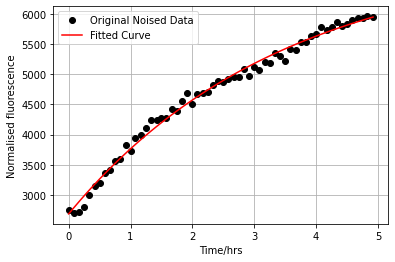

array([ 5.86798838e+07, -3.29334359e+01,  2.89157331e-01, -5.86729036e+07])

In [42]:
y = ss_fam_data.iloc[41]#/max(ss_fam_data.iloc[117])
popt, pcov = curve_fit(sigmoid, t.astype('float64'), y.astype('float64'), p0 = [np.max(y),np.median(t),1,np.min(y)], method = 'dogbox', maxfev=20000)
plt.figure()
plt.plot(t, y, 'ko', label="Original Noised Data")
plt.plot(t, sigmoid(t, *popt), 'r-', label="Fitted Curve")
plt.legend()
plt.grid();plt.ylabel('Normalised fluorescence');plt.xlabel('Time/hrs')
plt.show()
popt

In [43]:
def calcAverage(k_values):
  averaged_kvalues = []
  for i in range(len(k_values)-1):
    if (i+1)%3 == 0:
      continue
    if i%3 == 0:
      if k_values[i] == None:
        k_values[i] = k_values[i+1]
        averaged_kvalues.append((k_values[i]+k_values[i+1])/2)
        continue
      if k_values[i+1] == None:
        averaged_kvalues.append((k_values[i]+k_values[i+1])/2)
        continue
      if k_values[i] < 0.05: #or k_values[i] > 100:
        k_values[i] = k_values[i+1]
      if k_values[i+1] < 0.05: #or k_values[i+1] > 100:
        k_values[i+1] = k_values[i]
      averaged_kvalues.append((k_values[i]+k_values[i+1])/2)
  return averaged_kvalues

In [44]:
averaged_kvalues_ss_exp = calcAverage(k_values_ss_exp)
averaged_kvalues_ss_sig = calcAverage(k_values_ss_sig)
averaged_kvalues_ds_exp = calcAverage(k_values_ds_exp)
averaged_kvalues_ds_sig = calcAverage(k_values_ds_sig)

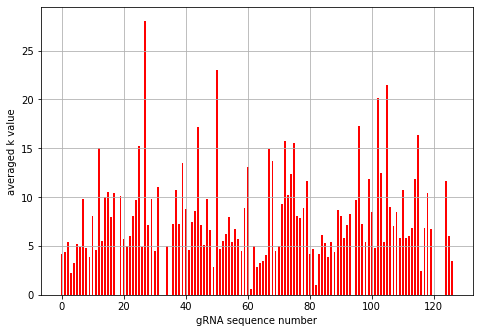

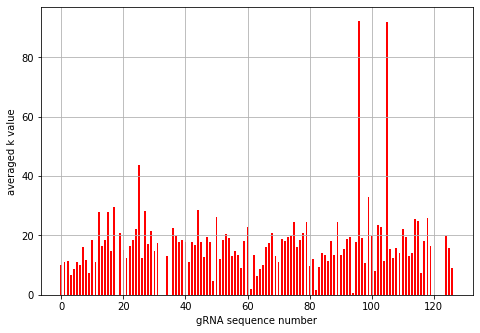

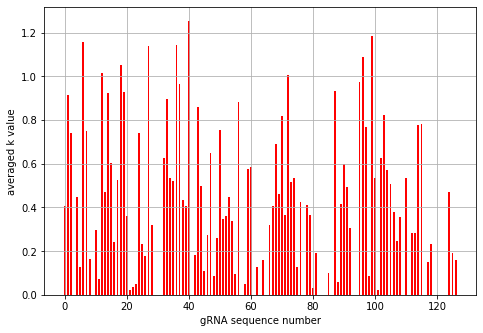

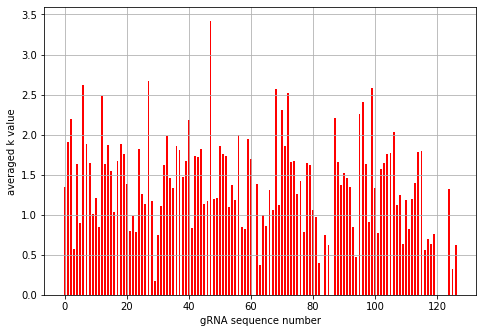

In [45]:
x = np.arange(len(averaged_kvalues_ss_exp[:-1]))
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.bar(x, averaged_kvalues_ss_exp[:-1], width = 0.6, color = 'r')
plt.xlabel('gRNA sequence number');plt.ylabel('averaged k value');plt.grid()
plt.show()

x = np.arange(len(averaged_kvalues_ss_sig[:-1]))
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.bar(x, averaged_kvalues_ss_sig[:-1], width = 0.6, color = 'r')
plt.xlabel('gRNA sequence number');plt.ylabel('averaged k value');plt.grid()
plt.show()

x = np.arange(len(averaged_kvalues_ds_exp[:-1]))
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.bar(x, averaged_kvalues_ds_exp[:-1], width = 0.6, color = 'r')
plt.xlabel('gRNA sequence number');plt.ylabel('averaged k value');plt.grid()
plt.show()

x = np.arange(len(averaged_kvalues_ds_sig[:-1]))
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.bar(x, averaged_kvalues_ds_sig[:-1], width = 0.6, color = 'r')
plt.xlabel('gRNA sequence number');plt.ylabel('averaged k value');plt.grid()
plt.show()

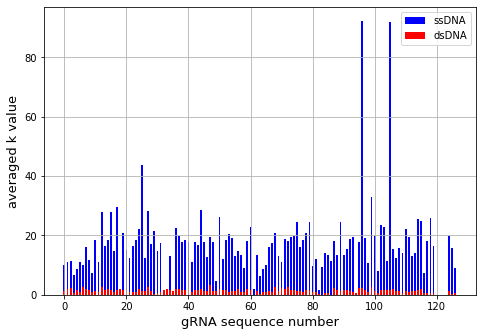

In [46]:
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])

x = np.arange(len(averaged_kvalues_ss_sig[:-1]))
ax.bar(x, averaged_kvalues_ss_sig[:-1], width = 0.6, color = 'b', label = 'ssDNA')

x = np.arange(len(averaged_kvalues_ds_sig[:-1]))
ax.bar(x, averaged_kvalues_ds_sig[:-1], width = 0.6, color = 'r', label = 'dsDNA')
# plt.title('Comparison of ss and ds k values (using logistic)')
plt.xlabel('gRNA sequence number', fontsize=13);plt.ylabel('averaged k value', fontsize=13);plt.grid()
plt.legend()
plt.show()

In [56]:
df = pd.DataFrame({'gRNA':[record.seq for record in records],'target':[record.seq for record in records_targets],'ssDNA_k':averaged_kvalues_ss_sig[:-1], 'dsDNA_k':averaged_kvalues_ds_sig[:-1]})
df.to_csv('./Outputs/kvalues.csv')

In [47]:
#Calculate GC content of gRNA
gc_content_grna = [] 
for i in range(len(records)):
  count = 0
  for l in range(len(records[i].seq)):
    if records[i].seq[l] == 'g' or records[i].seq[l] == 'c':
      count += 1
  gc_content_grna.append(count/len(records[i].seq))

In [48]:
#Calculate GC content of target
gc_content_target = [] 
for i in range(len(records_targets)):
  count = 0
  for l in range(len(records_targets[i].seq)):
    if records_targets[i].seq[l] == 'g' or records_targets[i].seq[l] == 'c':
      count += 1
  gc_content_target.append(count/len(records_targets[i].seq))

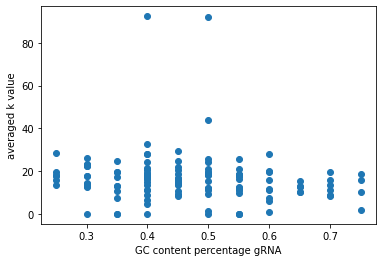

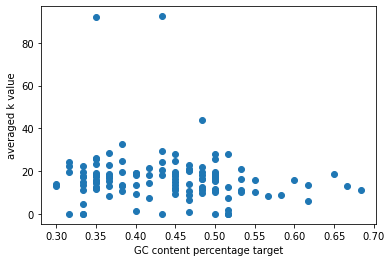

In [41]:
plt.scatter(gc_content_grna, averaged_kvalues_ss_sig[:-1])
plt.ylabel('averaged k value'); plt.xlabel('GC content percentage gRNA');plt.show()

plt.scatter(gc_content_target, averaged_kvalues_ss_sig[:-1])
plt.ylabel('averaged k value'); plt.xlabel('GC content percentage target');plt.show()

In [42]:
df = pd.DataFrame(data = {'gc_values_grna' : gc_content_grna, 'gc_values_target' : gc_content_target, 'k_values_ss_sig' : averaged_kvalues_ss_sig[:-1]})
df = df.sort_values('gc_values_grna')

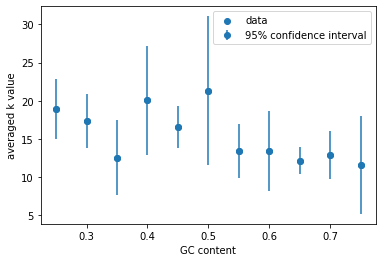

/Users/brendanhuo/opt/anaconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/brendanhuo/opt/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Users/brendanhuo/opt/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:262: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/brendanhuo/opt/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:222: RuntimeWarning: invalid value encountered in true_divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
/Users/brendanhuo/opt/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:254: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


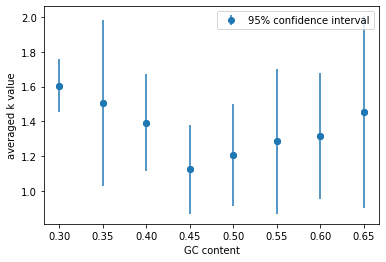

In [43]:
###Is it right to do it by distinct GC values??
gcs = set(gc_content_grna)
gc_kvalues_ss_sig = []
for gc in gcs:
  indices = list(filter(lambda x: gc_content_grna[x] == gc, range(len(gc_content_grna))))
  gc_kvalues_ss_sig.append([gc, np.mean([averaged_kvalues_ss_sig[i] for i in indices]), 2*np.std([averaged_kvalues_ss_sig[i] for i in indices])/np.sqrt(len(indices))])
gc_kvalues_ss_sig = np.array(gc_kvalues_ss_sig)

plt.scatter(gc_kvalues_ss_sig[:,0], gc_kvalues_ss_sig[:, 1], label = 'data')
plt.errorbar(gc_kvalues_ss_sig[:,0], gc_kvalues_ss_sig[:, 1], yerr=gc_kvalues_ss_sig[:, 2], fmt="o", label = '95% confidence interval')
plt.xlabel('GC content');plt.ylabel('averaged k value');plt.legend()
plt.show()

gcs = set(gc_content_target)
gc_kvalues_ds_sig = []
for gc in gcs:
  indices = list(filter(lambda x: gc_content_grna[x] == gc, range(len(gc_content_grna))))
  gc_kvalues_ds_sig.append([gc, np.mean([averaged_kvalues_ds_sig[i] for i in indices]), 2*np.std([averaged_kvalues_ds_sig[i] for i in indices])/np.sqrt(len(indices))])
gc_kvalues_ds_sig = np.array(gc_kvalues_ds_sig)

plt.scatter(gc_kvalues_ds_sig[:,0], gc_kvalues_ds_sig[:, 1])
plt.errorbar(gc_kvalues_ds_sig[:,0], gc_kvalues_ds_sig[:, 1], yerr=gc_kvalues_ds_sig[:, 2], fmt="o", label = '95% confidence interval')
plt.xlabel('GC content');plt.ylabel('averaged k value');plt.legend()
plt.show()

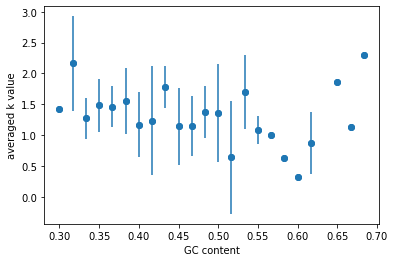

In [44]:
gcs = set(gc_content_target)
gc_kvalues = []
for gc in gcs:
  indices = list(filter(lambda x: gc_content_target[x] == gc, range(len(gc_content_target))))
  gc_kvalues.append([gc, np.mean([averaged_kvalues_ds_sig[i] for i in indices]), np.std([averaged_kvalues_ds_sig[i] for i in indices])])
gc_kvalues = np.array(gc_kvalues)

plt.scatter(gc_kvalues[:,0], gc_kvalues[:, 1])
plt.errorbar(gc_kvalues[:,0], gc_kvalues[:, 1], yerr=gc_kvalues[:, 2], fmt="o")
plt.xlabel('GC content');plt.ylabel('averaged k value')
plt.show()

Look at V of TTTV PAM site (position 20 of target)

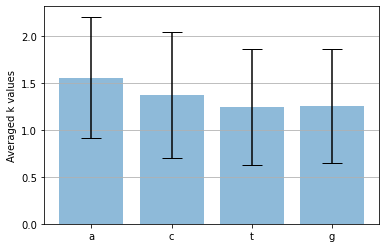

In [45]:
bases = ['a','c','t','g']
As = []
Cs = []
Ts = []
Gs = []
for i in range(len(records_targets)):
  if records_targets[i].seq[20] == 'a':
    As.append(i)
  elif records_targets[i].seq[20] == 'c':
    Cs.append(i)
  elif records_targets[i].seq[20] == 't':
    Ts.append(i)
  elif records_targets[i].seq[20] == 'g':
    Gs.append(i)
meanA = np.mean([averaged_kvalues_ds_sig[i] for i in As])
stdA = np.std([averaged_kvalues_ds_sig[i] for i in As])
meanC = np.mean([averaged_kvalues_ds_sig[i] for i in Cs])
stdC = np.std([averaged_kvalues_ds_sig[i] for i in Cs])
meanT = np.mean([averaged_kvalues_ds_sig[i] for i in Ts])
stdT = np.std([averaged_kvalues_ds_sig[i] for i in Ts])
meanG = np.mean([averaged_kvalues_ds_sig[i] for i in Gs])
stdG = np.std([averaged_kvalues_ds_sig[i] for i in Gs])
meansACTG = [meanA, meanC, meanT, meanG]
errorsACTG = [stdA, stdC, stdT, stdG]

fig, ax = plt.subplots()
ax.bar(np.arange(len(bases)), meansACTG, yerr=errorsACTG, align='center', alpha=0.5, ecolor='black', capsize=10)
ax.set_ylabel('Averaged k values')
ax.set_xticks(np.arange(len(bases)))
ax.set_xticklabels(bases)
ax.yaxis.grid(True)

#One hot encoding implementation

In [46]:
def one_hot_encode(seq):
    mapping = dict(zip("acgt", range(4)))    
    seq2 = [mapping[i] for i in seq]
    return np.eye(4)[seq2]
def one_hot_encode_duplets(seq):
    mapping = dict(zip(('aa', 'ac', 'ag', 'at', 'ca', 'cc', 'cg', 'ct', 'ga', 'gc', 'gg', 'gt', 'ta', 'tc', 'tg', 'tt'), range(16)))
    seq2 = []
    for i in range(len(seq)-1):
      seq2.append(mapping[seq[i:i+2]])
    return np.eye(16)[seq2]

In [47]:
print(one_hot_encode(records[0].seq))
records[0].seq

[[0. 1. 0. 0.]
 [0. 1. 0. 0.]
 [0. 0. 0. 1.]
 [0. 0. 1. 0.]
 [0. 1. 0. 0.]
 [0. 0. 0. 1.]
 [0. 0. 1. 0.]
 [0. 0. 1. 0.]
 [0. 0. 0. 1.]
 [0. 0. 1. 0.]
 [0. 0. 1. 0.]
 [0. 1. 0. 0.]
 [0. 0. 0. 1.]
 [0. 1. 0. 0.]
 [0. 1. 0. 0.]
 [1. 0. 0. 0.]
 [0. 0. 1. 0.]
 [0. 0. 0. 1.]
 [0. 0. 0. 1.]
 [0. 1. 0. 0.]]


Seq('cctgctggtggctccagttc')


# Create features 
Position specific features 0-79 are the base coding of the length 20 grna sequence (4xL), feature 80-159 are the base coding of the length 20 target section of the best alignment. 160-319 are the 40 bases about the length 20 aligned target. 320-623 are the position specific duplets (19* 4**2)

Just with first 80 features

In [49]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.datasets import make_regression
seed = 0
regr = RandomForestRegressor(max_depth=8, random_state=0, n_estimators = 2500)
# regr = RandomForestRegressor()

In [ ]:
np.random.seed(seed)
X = []
y = averaged_kvalues_ss_sig[:-1]
feature_names = []
for record in records:
  X.append(np.concatenate((one_hot_encode(record.seq), one_hot_encode(record.seq)), axis = None).ravel()) ###Perfect alignment for now
X = np.array(X)
y = np.array(y)
mask = np.random.rand(len(averaged_kvalues_ss_sig)-1) < 0.75
regr.fit(X[mask], y[mask])
map = dict(zip(range(4), "acgt"))
for i in range(80):
  feature_names.append('grnaposition{}, {}'.format(i//20+1, map[i%4]))
for i in range(80):
  feature_names.append('targetalignedaposition{}, {}'.format(i//20+1, map[i%4]))

In [ ]:
print('R2 score: ' + str((regr.score(X[~mask], y[~mask]))))
len(X[0]), len(feature_names)

R2 score: 0.001032421134807393


(160, 160)

Adding 160 features of target 

In [ ]:
np.random.seed(seed)
X = []
y = averaged_kvalues_ss_sig[:-1]
for i in range(len(records)):
  k = align(records[i].seq, records_targets[i].seq)
  X.append(np.concatenate((one_hot_encode(records[i].seq), one_hot_encode(records[i].seq), one_hot_encode(records_targets[i].seq[:k]), one_hot_encode(records_targets[i].seq[k+20:])), axis = None).ravel())
X = np.array(X)
y = np.array(y)
mask = np.random.rand(len(averaged_kvalues_ss_sig)-1) < 0.75
regr.fit(X[mask], y[mask])
map = dict(zip(range(4), "acgt"))
for i in range(160):
  feature_names.append('targetposition{}, {}'.format(i//40+1, map[i%4]))

In [ ]:
print('R2 score: ' + str((regr.score(X[~mask], y[~mask]))))
len(X[0]), len(feature_names)

R2 score: 0.0009542432825422331


(320, 320)

Adding duplet features

In [ ]:
np.random.seed(seed)
X = []
y = averaged_kvalues_ss_sig[:-1]
for i in range(len(records)):
  k = align(records[i].seq, records_targets[i].seq)
  X.append(np.concatenate((one_hot_encode(records[i].seq), one_hot_encode(records[i].seq), one_hot_encode(records_targets[i].seq[:k]), one_hot_encode(records_targets[i].seq[k+20:]), one_hot_encode_duplets(record.seq)), axis = None).ravel())
X = np.array(X)
y = np.array(y)
mask = np.random.rand(len(averaged_kvalues_ss_sig)-1) < 0.75
regr.fit(X[mask], y[mask])
map = dict(zip(range(16), ('aa', 'ac', 'ag', 'at', 'ca', 'cc', 'cg', 'ct', 'ga', 'gc', 'gg', 'gt', 'ta', 'tc', 'tg', 'tt')))
for i in range(304):
  feature_names.append('grnaposition{}, {}'.format(i//19+1, map[i%16]))

In [ ]:
print('R2 score: ' + str((regr.score(X[~mask], y[~mask]))))
len(X[0]), len(feature_names)

R2 score: 0.0006214825794442769


(624, 624)

## So position specific features do not seem to have any effect on efficacy, we need some way of identifying non position specific features (e.g. GC etc.)

Add ds/ss

In [ ]:
np.random.seed(seed)
X = []
y = np.append(averaged_kvalues_ss_sig[:-1], averaged_kvalues_ds_sig[:-1])
for i in range(len(records)):
  X.append(np.concatenate((one_hot_encode(records[i].seq), one_hot_encode(records[i].seq), one_hot_encode(records_targets[i].seq[:k]), one_hot_encode(records_targets[i].seq[k+20:]), one_hot_encode_duplets(record.seq), 1), axis = None).ravel())
for i in range(len(records)):
  X.append(np.concatenate((one_hot_encode(records[i].seq), one_hot_encode(records[i].seq), one_hot_encode(records_targets[i].seq[:k]), one_hot_encode(records_targets[i].seq[k+20:]), one_hot_encode_duplets(record.seq), 0), axis = None).ravel())
X = np.array(X)
y = np.array(y)
mask = np.random.rand(len(y)) < 0.75
regr.fit(X[mask], y[mask])
feature_names.append('ss/ds[1/0]')

In [ ]:
print('R2 score: ' + str((regr.score(X[~mask], y[~mask]))))
len(X[0]), len(feature_names)

R2 score: 0.33172321595138665


(625, 625)

Add GC of grna and target

In [50]:
def calcGC(seq):
  gc_content = [] 
  count = 0
  for l in range(len(seq)):
    if seq[l] == 'g' or seq[l] == 'c':
      count += 1
  return count/len(seq)

In [ ]:
np.random.seed(seed)
X = []
y = np.append(averaged_kvalues_ss_sig[:-1], averaged_kvalues_ds_sig[:-1])
for i in range(len(records)):
  X.append(np.concatenate((one_hot_encode(records[i].seq), one_hot_encode(records[i].seq), one_hot_encode(records_targets[i].seq[:k]), one_hot_encode(records_targets[i].seq[k+20:]), one_hot_encode_duplets(records[i].seq), 1, calcGC(records[i].seq), calcGC(records_targets[i].seq)), axis = None).ravel())
for i in range(len(records)):
  X.append(np.concatenate((one_hot_encode(records[i].seq), one_hot_encode(records[i].seq), one_hot_encode(records_targets[i].seq[:k]), one_hot_encode(records_targets[i].seq[k+20:]), one_hot_encode_duplets(records[i].seq), 0, calcGC(records[i].seq), calcGC(records_targets[i].seq)), axis = None).ravel())
X = np.array(X)
y = np.array(y)
mask = np.random.rand(len(y)) < 0.75
regr.fit(X[mask], y[mask])
feature_names.append('gc_grna')
feature_names.append('gc_target')

In [ ]:
print('R2 score: ' + str(abs(regr.score(X[~mask], y[~mask]))))
len(X[0]), len(feature_names)

R2 score: 0.2364988666663821


(627, 627)

In [51]:
def countMotifs(seq, motifs):
  counts = []
  for motif in motifs:
    count = 0
    for i in range(len(seq) - len(motif)):
      if seq[i:i+len(motif)] == motif:
        count += 1
    counts.append(count/(len(seq) - len(motif)))
  return counts

In [52]:
bases = ['a','c','g','t']
motifs_to_look_for = []
for i in range(len(bases)):
  motifs_to_look_for.append(bases[i])
  for j in range(len(bases)):
    motifs_to_look_for.append(bases[i]+bases[j])
    for k in range(len(bases)):
      motifs_to_look_for.append(bases[i]+bases[j]+bases[k])
      # for l in range(len(bases)):
      #   motifs_to_look_for.append(bases[i]+bases[j]+bases[k]+bases[l])
motifs_to_look_for.append('aaaa')
motifs_to_look_for.append('cccc')
motifs_to_look_for.append('gggg')
motifs_to_look_for.append('tttt')

In [53]:
np.random.seed(seed)
feature_names = []
X = []
y = np.append(averaged_kvalues_ss_sig[:-1], averaged_kvalues_ds_sig[:-1])
for i in range(len(records)):
  X.append(np.concatenate((one_hot_encode(records[i].seq), one_hot_encode(records[i].seq), one_hot_encode(records_targets[i].seq[:k]), one_hot_encode(records_targets[i].seq[k+20:]), one_hot_encode_duplets(records[i].seq), 1
                           , calcGC(records[i].seq), calcGC(records_targets[i].seq), countMotifs(records[i].seq, motifs_to_look_for)), axis = None).ravel())
for i in range(len(records)):
  X.append(np.concatenate((one_hot_encode(records[i].seq), one_hot_encode(records[i].seq), one_hot_encode(records_targets[i].seq[:k]), one_hot_encode(records_targets[i].seq[k+20:]), one_hot_encode_duplets(records[i].seq), 0
                           , calcGC(records[i].seq), calcGC(records_targets[i].seq), countMotifs(records[i].seq, motifs_to_look_for)), axis = None).ravel())
X = np.array(X)
y = np.array(y)
mask = np.random.rand(len(y)) < 0.75
regr.fit(X[mask], y[mask])

map = dict(zip(range(4), "acgt"))
for i in range(80):
  feature_names.append('grnaposition{}, {}'.format(i//20+1, map[i%4]))
for i in range(80):
  feature_names.append('targetalignedaposition{}, {}'.format(i//20+1, map[i%4]))
for i in range(80):
  feature_names.append('targetposition{}, {}'.format(i//20+1, map[i%4]))
for i in range(80):
  feature_names.append('targetposition{}, {}'.format(i//20+41, map[i%4]))
map = dict(zip(range(16), ('aa', 'ac', 'ag', 'at', 'ca', 'cc', 'cg', 'ct', 'ga', 'gc', 'gg', 'gt', 'ta', 'tc', 'tg', 'tt')))
for i in range(304):
  feature_names.append('grnaposition{}, {}'.format(i//19+1, map[i%16]))
feature_names.append('ss/ds[1/0]')
feature_names.append('gc_grna')
feature_names.append('gc_target')
for motif in motifs_to_look_for:
  feature_names.append('Motif: ' + motif)

In [54]:
print('R2 score: ' + str(abs(regr.score(X[~mask], y[~mask]))))
len(X[0]), len(feature_names)

R2 score: 0.3504958346693132


(715, 715)

In [55]:
# Extract single tree
estimator = regr.estimators_[5]

In [62]:
from sklearn.tree import export_graphviz
# Export as dot file
export_graphviz(estimator, out_file='./Outputs/tree.dot', 
                feature_names = feature_names,
                class_names = ['k_value'],
                rounded = True, proportion = False, 
                precision = 2, filled = True)

In [66]:
import pydot
(graph,) = pydot.graph_from_dot_file('./Outputs/tree.dot')
graph.write_png('./Outputs/tree.png')

FileNotFoundError: [Errno 2] "dot" not found in path.

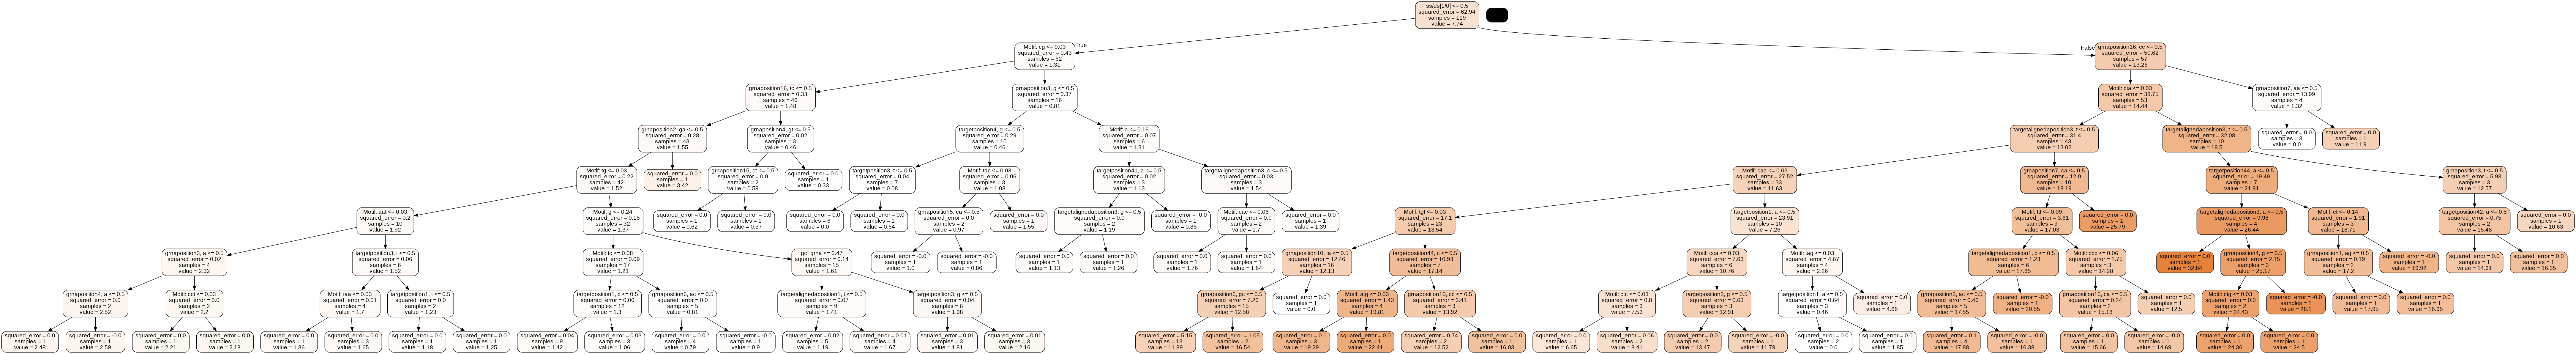

In [65]:
# Display in jupyter notebook
from IPython.display import Image
Image(filename = './Outputs/tree.png')

In [67]:
d = {'features': feature_names, 'importance_values': regr.feature_importances_}
df = pd.DataFrame(data = d)
df.sort_values('importance_values', ascending = False).head(100)

,features,importance_values
624,ss/ds[1/0],0.432813
389,"grnaposition4, cc",0.072644
674,Motif: gat,0.046971
631,Motif: aag,0.038442
377,"grnaposition4, gc",0.021236
...,...,...
643,Motif: at,0.000689
86,"targetalignedaposition1, g",0.000681
696,Motif: tc,0.000681
370,"grnaposition3, ag",0.000678


In [ ]:
regrall = RandomForestRegressor(max_depth=8, random_state=0, n_estimators = 2500)

feature_names = []
k = 20
X = []
y = np.append(averaged_kvalues_ss_sig[:-1], averaged_kvalues_ds_sig[:-1])
for i in range(len(records)):
  X.append(np.concatenate((one_hot_encode(records[i].seq), one_hot_encode(records[i].seq), one_hot_encode(records_targets[i].seq[:k]), one_hot_encode(records_targets[i].seq[k+20:]), one_hot_encode_duplets(records[i].seq), 1
                           , calcGC(records[i].seq), calcGC(records_targets[i].seq), countMotifs(records[i].seq, motifs_to_look_for)), axis = None).ravel())
for i in range(len(records)):
  X.append(np.concatenate((one_hot_encode(records[i].seq), one_hot_encode(records[i].seq), one_hot_encode(records_targets[i].seq[:k]), one_hot_encode(records_targets[i].seq[k+20:]), one_hot_encode_duplets(records[i].seq), 0
                           , calcGC(records[i].seq), calcGC(records_targets[i].seq), countMotifs(records[i].seq, motifs_to_look_for)), axis = None).ravel())
X = np.array(X)
y = np.array(y)
regrall.fit(X, y)

map = dict(zip(range(4), "acgt"))
for i in range(80):
  feature_names.append('grnaposition{}, {}'.format(i//20+1, map[i%4]))
for i in range(80):
  feature_names.append('targetalignedaposition{}, {}'.format(i//20+1, map[i%4]))
for i in range(80):
  feature_names.append('targetposition{}, {}'.format(i//20+1, map[i%4]))
for i in range(80):
  feature_names.append('targetposition{}, {}'.format(i//20+41, map[i%4]))
map = dict(zip(range(16), ('aa', 'ac', 'ag', 'at', 'ca', 'cc', 'cg', 'ct', 'ga', 'gc', 'gg', 'gt', 'ta', 'tc', 'tg', 'tt')))
for i in range(304):
  feature_names.append('grnaposition{}, {}'.format(i//19+1, map[i%16]))
feature_names.append('ss/ds[1/0]')
feature_names.append('gc_grna')
feature_names.append('gc_target')
for motif in motifs_to_look_for:
  feature_names.append('Motif: ' + motif)
# feature_names = np.concatenate((feature_names, motifs_to_look_for))

importances = regrall.feature_importances_ / 10
for i in range(1,10):
  regrall = RandomForestRegressor(max_depth=8, random_state=i, n_estimators = 2500)
  regrall.fit(X, y)
  importances += regrall.feature_importances_ / 10


In [ ]:
d = {'features': feature_names, 'importance_values': importances }
df = pd.DataFrame(data = d)
df.sort_values('importance_values', ascending = False).head(100)
df_feat = df[df.importance_values > 0.001]

,features,importance_values
624,ss/ds[1/0],0.469398
674,gat,0.044893
691,ta,0.032247
389,"grnaposition4, cc",0.024778
377,"grnaposition4, gc",0.024627
...,...,...
119,"targetalignedaposition2, t",0.000825
264,"targetposition3, a",0.000819
656,ccc,0.000819
250,"targetposition3, g",0.000815


In [ ]:
df.to_pickle("./Outputs/df_feat.pkl")

In [82]:
output = pd.read_pickle("./Outputs/df_feat.pkl")
# for i in range(len(records)):
#   print(countMotifs(records[i].seq, ['gat']))
output = output[output.importance_values > 0.001]
output.sort_values('importance_values', ascending = False).head(10)

,features,importance_values
624,ss/ds[1/0],0.655883
691,Motif: ta,0.055385
561,"grnaposition13, ac",0.013542
349,"grnaposition2, tc",0.008273
539,"grnaposition12, gt",0.008191
245,"targetposition41, c",0.007346
486,"grnaposition9, cg",0.007075
579,"grnaposition14, at",0.005270


(array([-1.,  0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.]),
 [Text(-1.0, 0, 'grnaposition14, at'),
  Text(0.0, 0, 'ss/ds[1/0]'),
  Text(1.0, 0, 'Motif: ta'),
  Text(2.0, 0, 'grnaposition13, ac'),
  Text(3.0, 0, 'grnaposition2, tc'),
  Text(4.0, 0, 'grnaposition12, gt'),
  Text(5.0, 0, 'targetposition41, c'),
  Text(6.0, 0, 'grnaposition9, cg'),
  Text(7.0, 0, 'grnaposition14, at'),
  Text(8.0, 0, '')])

<Figure size 432x288 with 0 Axes>

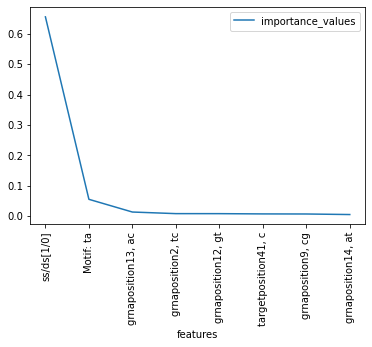

In [72]:
plt.figure()
output.sort_values('importance_values', ascending = False).plot('features', 'importance_values')
plt.xticks(rotation=90)

In [81]:
X = []
y = np.append(averaged_kvalues_ss_sig[:-1], averaged_kvalues_ds_sig[:-1])
for i in range(len(records)):
  X.append(np.concatenate((one_hot_encode(records[i].seq), one_hot_encode(records[i].seq), one_hot_encode(records_targets[i].seq[:k]), one_hot_encode(records_targets[i].seq[k+20:]), one_hot_encode_duplets(records[i].seq), 1
                           , calcGC(records[i].seq), calcGC(records_targets[i].seq), countMotifs(records[i].seq, motifs_to_look_for)), axis = None).ravel())
for i in range(len(records)):
  X.append(np.concatenate((one_hot_encode(records[i].seq), one_hot_encode(records[i].seq), one_hot_encode(records_targets[i].seq[:k]), one_hot_encode(records_targets[i].seq[k+20:]), one_hot_encode_duplets(records[i].seq), 0
                           , calcGC(records[i].seq), calcGC(records_targets[i].seq), countMotifs(records[i].seq, motifs_to_look_for)), axis = None).ravel())
X = np.array(X)
y = np.array(y)

In [83]:
X_reduced = X[:,output.index]

In [84]:
# Import train_test_split function
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVR

# Split dataset into training set and test set
X_train, X_test, y_train, y_test = train_test_split(X_reduced, y, test_size=0.1,random_state=57) # 75% training and 25% test

from sklearn import preprocessing
from sklearn import utils

lab_enc = preprocessing.LabelEncoder()
encoded_ytrain = lab_enc.fit_transform(y_train)
encoded_ytest = lab_enc.fit_transform(y_test)

In [85]:
#Import svm model
from sklearn import svm

#Create a svm Classifier
clf = make_pipeline(StandardScaler(), SVR(kernel = 'linear'))

#Train the model using the training sets
# clf.fit(X_train, encoded_ytrain)
clf.fit(X_train, y_train)

#Predict the response for test dataset
y_pred = clf.predict(X_test)

In [86]:
#Import scikit-learn metrics module for accuracy calculation
from sklearn import metrics

# Model Accuracy: how often is the classifier correct?
# print("Accuracy:",metrics.mean_absolute_percentage_error(encoded_ytest, y_pred))
print("Accuracy:", abs(clf.score(X_test, y_test, sample_weight=None)))

Accuracy: 0.9348818157376237


In [88]:
from sklearn.metrics import explained_variance_score
values = []
for i in range(250):
  X_train, X_test, y_train, y_test = train_test_split(X_reduced, y, test_size=0.1,random_state=i)

  lab_enc = preprocessing.LabelEncoder()
  encoded_ytrain = lab_enc.fit_transform(y_train)
  encoded_ytest = lab_enc.fit_transform(y_test)

  #Create a svm Classifier
  # clf = svm.SVC(kernel='rbf') # RBF Kernel
  clf = make_pipeline(StandardScaler(), SVR(kernel = 'linear'))

  #Train the model using the training sets
  # clf.fit(X_train, encoded_ytrain)
  clf.fit(X_train, y_train)

  #Predict the response for test dataset
  y_pred = clf.predict(X_reduced)

  for i in range(len(y_pred)):
    if y_pred[i] < 0:
      y_pred[i] = 0
  # values.append(metrics.mean_absolute_percentage_error(encoded_ytest, y_pred))
  values.append(explained_variance_score(y, y_pred))
print('Accuracy: {}'.format(np.mean(values)))
np.argmax(values)

Accuracy: 0.4618820473035755


4

In [89]:
y_predicted = clf.predict(X_reduced)
for i in range(len(y_predicted)):
    if y_predicted[i] < 0:
      y_predicted[i] = 0

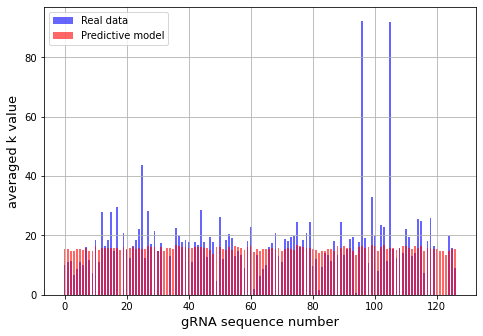

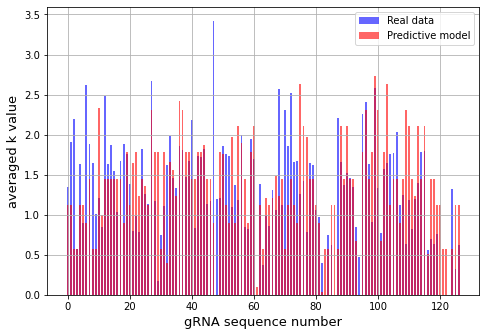

In [90]:
fig = plt.figure(1)
ax = fig.add_axes([0,0,1,1])
x = np.arange(len(averaged_kvalues_ss_sig[:-1]))
ax.bar(x, averaged_kvalues_ss_sig[:-1], width = 0.6, color = 'b', alpha = 0.6,label = 'Real data')

ax.bar(x, y_predicted[:len(averaged_kvalues_ss_sig[:-1])], width = 0.6, color = 'r', alpha = 0.6, label = 'Predictive model')
# plt.title('Comparison of ss and ds k values (using logistic)')
plt.xlabel('gRNA sequence number', fontsize=13);plt.ylabel('averaged k value', fontsize=13);plt.grid()
plt.legend()
plt.show()

fig = plt.figure(2)
ax = fig.add_axes([0,0,1,1])
x = np.arange(len(averaged_kvalues_ds_sig[:-1]))
ax.bar(x, averaged_kvalues_ds_sig[:-1], width = 0.6, color = 'b', alpha = 0.6,label = 'Real data')

ax.bar(x, y_predicted[len(averaged_kvalues_ds_sig[:-1]):], width = 0.6, color = 'r', alpha = 0.6, label = 'Predictive model')
# plt.title('Comparison of ss and ds k values (using logistic)')
plt.xlabel('gRNA sequence number', fontsize=13);plt.ylabel('averaged k value', fontsize=13);plt.grid()
plt.legend()
plt.show()

In [ ]:
np.concatenate((averaged_kvalues_ss_sig[:-1],averaged_kvalues_ds_sig[:-1]))

In [ ]:
regrall = RandomForestRegressor(max_depth=8, random_state=0, n_estimators = 2500)

feature_names = []
k = 20
X = []
y = averaged_kvalues_ss_sig[:-1]
for i in range(len(records)):
  X.append(np.concatenate((one_hot_encode(records[i].seq), one_hot_encode(records[i].seq), one_hot_encode(records_targets[i].seq[:k]), one_hot_encode(records_targets[i].seq[k+20:]), one_hot_encode_duplets(records[i].seq)
                           , calcGC(records[i].seq), calcGC(records_targets[i].seq), countMotifs(records[i].seq, motifs_to_look_for)), axis = None).ravel())

X = np.array(X)
y = np.array(y)
regrall.fit(X, y)

map = dict(zip(range(4), "acgt"))
for i in range(80):
  feature_names.append('grnaposition{}, {}'.format(i//20+1, map[i%4]))
for i in range(80):
  feature_names.append('targetalignedaposition{}, {}'.format(i//20+1, map[i%4]))
for i in range(80):
  feature_names.append('targetposition{}, {}'.format(i//20+1, map[i%4]))
for i in range(80):
  feature_names.append('targetposition{}, {}'.format(i//20+41, map[i%4]))
map = dict(zip(range(16), ('aa', 'ac', 'ag', 'at', 'ca', 'cc', 'cg', 'ct', 'ga', 'gc', 'gg', 'gt', 'ta', 'tc', 'tg', 'tt')))
for i in range(304):
  feature_names.append('grnaposition{}, {}'.format(i//19+1, map[i%16]))
feature_names.append('gc_grna')
feature_names.append('gc_target')
for motif in motifs_to_look_for:
  feature_names.append('Motif: ' + motif)

importances = regrall.feature_importances_ / 10
for i in range(1,10):
  regrall = RandomForestRegressor(max_depth=8, random_state=i, n_estimators = 2500)
  regrall.fit(X, y)
  importances += regrall.feature_importances_ / 10


In [ ]:
d = {'features': feature_names, 'importance_values': importances }
df = pd.DataFrame(data = d)
# display(df.sort_values('importance_values', ascending = False).head(100))
df_feat = df[df.importance_values > 0.01]

In [ ]:
df.to_pickle(",/Outputs/df_feat_ss.pkl")

In [80]:
output_ss = pd.read_pickle("./Outputs/df_feat_ss.pkl")
# for i in range(len(records)):
#   print(countMotifs(records[i].seq, ['gat']))
output_ss = output_ss[output_ss.importance_values > 0.01]
output_ss.sort_values('importance_values', ascending = False).head(10)

,features,importance_values
690,Motif: ta,0.157469
561,"grnaposition13, ac",0.038749
349,"grnaposition2, tc",0.023808
539,"grnaposition12, gt",0.023165
245,"targetposition41, c",0.020563
486,"grnaposition9, cg",0.019890
579,"grnaposition14, at",0.015637
625,gc_target,0.011646


In [ ]:
X_ss = []
k = 20
for i in range(len(records)):
  X_ss.append(np.concatenate((one_hot_encode(records[i].seq), one_hot_encode(records[i].seq), one_hot_encode(records_targets[i].seq[:k]), one_hot_encode(records_targets[i].seq[k+20:]), one_hot_encode_duplets(records[i].seq)
                           , calcGC(records[i].seq), calcGC(records_targets[i].seq), countMotifs(records[i].seq, motifs_to_look_for)), axis = None).ravel())

X_reduced_ss = np.array(X_ss)[:,output_ss.index]

In [ ]:
from sklearn.metrics import explained_variance_score
values = []
for i in range(250):
  X_train, X_test, y_train, y_test = train_test_split(X_reduced_ss, averaged_kvalues_ss_sig[:-1], test_size=0.1,random_state=i)

  lab_enc = preprocessing.LabelEncoder()
  encoded_ytrain = lab_enc.fit_transform(y_train)
  encoded_ytest = lab_enc.fit_transform(y_test)

  #Create a svm Classifier
  # clf = svm.SVC(kernel='rbf') # RBF Kernel
  clf = make_pipeline(StandardScaler(), SVR(kernel = 'rbf'))

  #Train the model using the training sets
  # clf.fit(X_train, encoded_ytrain)
  clf.fit(X_train, y_train)

  #Predict the response for test dataset
  y_pred = clf.predict(X_reduced_ss)

  for i in range(len(y_pred)):
    if y_pred[i] < 0:
      y_pred[i] = 0
  # values.append(metrics.mean_absolute_percentage_error(y_test, y_pred))
  # if abs(clf.score(X_test, y_test, sample_weight = None)) < 1:
  #   values.append(abs(clf.score(X_test, y_test, sample_weight = None)))
  # else:
  #   values.append(0)
    
  values.append(explained_variance_score(averaged_kvalues_ss_sig[:-1], y_pred))
print('Accuracy: {}'.format(np.mean(values)))
np.argmax(values)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_reduced_ss, averaged_kvalues_ss_sig[:-1], test_size=0.1,random_state=np.argmax(values))

lab_enc = preprocessing.LabelEncoder()
encoded_ytrain = lab_enc.fit_transform(y_train)
encoded_ytest = lab_enc.fit_transform(y_test)

#Create a svm Classifier
# clf = svm.SVC(kernel='rbf') # RBF Kernel
clf = make_pipeline(StandardScaler(), SVR(kernel = 'rbf'))

#Train the model using the training sets
# clf.fit(X_train, encoded_ytrain)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_reduced_ss)

# abs(clf.score(X_test, y_test, sample_weight = None))
explained_variance_score(averaged_kvalues_ss_sig[:-1],y_pred)

In [ ]:
y_predicted = clf.predict(X_reduced_ss)
for i in range(len(y_predicted)):
    if y_predicted[i] < 0:
      y_predicted[i] = 0

In [ ]:
fig = plt.figure(1)
ax = fig.add_axes([0,0,1,1])
x = np.arange(len(averaged_kvalues_ss_sig[:-1]))
ax.bar(x, averaged_kvalues_ss_sig[:-1], width = 0.6, color = 'b', alpha = 0.6,label = 'Real data')

ax.bar(x, y_predicted[:len(averaged_kvalues_ss_sig[:-1])], width = 0.6, color = 'r', alpha = 0.6, label = 'Predictive model')
# plt.title('Comparison of ss and ds k values (using logistic)')
plt.xlabel('gRNA sequence number', fontsize=13);plt.ylabel('averaged k value', fontsize=13);plt.grid()
plt.legend()
plt.show()


with ds

regrall = RandomForestRegressor(max_depth=8, random_state=0, n_estimators = 2500)

feature_names = []
k = 20
X = []
y = averaged_kvalues_ds_sig[:-1]
for i in range(len(records)):
  X.append(np.concatenate((one_hot_encode(records[i].seq), one_hot_encode(records[i].seq), one_hot_encode(records_targets[i].seq[:k]), one_hot_encode(records_targets[i].seq[k+20:]), one_hot_encode_duplets(records[i].seq)
                           , calcGC(records[i].seq), calcGC(records_targets[i].seq), countMotifs(records[i].seq, motifs_to_look_for)), axis = None).ravel())

X = np.array(X)
y = np.array(y)
regrall.fit(X, y)

map = dict(zip(range(4), "acgt"))
for i in range(80):
  feature_names.append('grnaposition{}, {}'.format(i//20+1, map[i%4]))
for i in range(80):
  feature_names.append('targetalignedaposition{}, {}'.format(i//20+1, map[i%4]))
for i in range(80):
  feature_names.append('targetposition{}, {}'.format(i//20+1, map[i%4]))
for i in range(80):
  feature_names.append('targetposition{}, {}'.format(i//20+41, map[i%4]))
map = dict(zip(range(16), ('aa', 'ac', 'ag', 'at', 'ca', 'cc', 'cg', 'ct', 'ga', 'gc', 'gg', 'gt', 'ta', 'tc', 'tg', 'tt')))
for i in range(304):
  feature_names.append('grnaposition{}, {}'.format(i//19+1, map[i%16]))
feature_names.append('gc_grna')
feature_names.append('gc_target')
for motif in motifs_to_look_for:
  feature_names.append('Motif: ' + motif)

importances = regrall.feature_importances_ / 10
for i in range(1,10):
  regrall = RandomForestRegressor(max_depth=8, random_state=i, n_estimators = 2500)
  regrall.fit(X, y)
  importances += regrall.feature_importances_ / 10

In [ ]:
d = {'features': feature_names, 'importance_values': importances }
df = pd.DataFrame(data = d)
# display(df.sort_values('importance_values', ascending = False).head(100))
df_feat = df[df.importance_values > 0.01]

In [ ]:
df.to_pickle("./Outputs/df_feat_ds.pkl")

In [91]:
output_ds = pd.read_pickle("./Outputs/df_feat_ds.pkl")
# for i in range(len(records)):
#   print(countMotifs(records[i].seq, ['gat']))
output_ds = output_ds[output_ds.importance_values>0.01]
output_ds.sort_values('importance_values', ascending = False).head(100)

,features,importance_values
690,Motif: ta,0.072435
625,gc_target,0.020633
258,"targetposition41, g",0.018253
634,Motif: acc,0.014690
685,Motif: gta,0.013518
647,Motif: c,0.012962
561,"grnaposition13, ac",0.012910
627,Motif: aa,0.011521
653,Motif: cc,0.010926
668,Motif: g,0.010315


In [92]:
X_ds = []
k = 20
for i in range(len(records)):
  X_ds.append(np.concatenate((one_hot_encode(records[i].seq), one_hot_encode(records[i].seq), one_hot_encode(records_targets[i].seq[:k]), one_hot_encode(records_targets[i].seq[k+20:]), one_hot_encode_duplets(records[i].seq)
                           , calcGC(records[i].seq), calcGC(records_targets[i].seq), countMotifs(records[i].seq, motifs_to_look_for)), axis = None).ravel())

X_reduced_ds = np.array(X_ds)[:,output_ds.index]

In [93]:
values = []
for i in range(250):
  X_train, X_test, y_train, y_test = train_test_split(X_reduced_ds, averaged_kvalues_ds_sig[:-1], test_size=0.1,random_state=i)

  lab_enc = preprocessing.LabelEncoder()
  encoded_ytrain = lab_enc.fit_transform(y_train)
  encoded_ytest = lab_enc.fit_transform(y_test)

  #Create a svm Classifier
  # clf = svm.SVC(kernel='rbf') # RBF Kernel
  clf = make_pipeline(StandardScaler(), SVR(kernel = 'linear'))

  #Train the model using the training sets
  # clf.fit(X_train, encoded_ytrain)
  clf.fit(X_train, y_train)

  #Predict the response for test dataset
  y_pred = clf.predict(X_reduced_ds)

  for i in range(len(y_pred)):
    if y_pred[i] < 0:
      y_pred[i] = 0
  # values.append(metrics.mean_absolute_percentage_error(y_test, y_pred))
  # if abs(clf.score(X_test, y_test, sample_weight = None)) < 1:
  #   values.append(abs(clf.score(X_test, y_test, sample_weight = None)))
  # else:
  #   values.append(0)
    
  values.append(abs(explained_variance_score(averaged_kvalues_ds_sig[:-1], y_pred)))
print('Accuracy: {}'.format(np.mean(values)))
np.argmax(values)

Accuracy: 0.23247448400113374


173

In [94]:
X_train, X_test, y_train, y_test = train_test_split(X_reduced_ds, averaged_kvalues_ds_sig[:-1], test_size=0.1,random_state=np.argmax(values))

lab_enc = preprocessing.LabelEncoder()
encoded_ytrain = lab_enc.fit_transform(y_train)
encoded_ytest = lab_enc.fit_transform(y_test)

#Create a svm Classifier
# clf = svm.SVC(kernel='rbf') # RBF Kernel
clf = make_pipeline(StandardScaler(), SVR(kernel = 'rbf'))

#Train the model using the training sets
# clf.fit(X_train, encoded_ytrain)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_reduced_ds)
# abs(clf.score(X_test, y_test, sample_weight = None))
explained_variance_score(averaged_kvalues_ds_sig[:-1], y_pred)

0.5124280017112659

In [95]:
y_predicted = clf.predict(X_reduced_ds)
for i in range(len(y_predicted)):
    if y_predicted[i] < 0:
      y_predicted[i] = 0

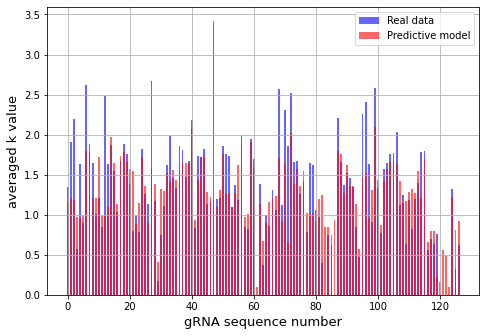

In [96]:
fig = plt.figure(1)
ax = fig.add_axes([0,0,1,1])
x = np.arange(len(averaged_kvalues_ss_sig[:-1]))
ax.bar(x, averaged_kvalues_ds_sig[:-1], width = 0.6, color = 'b', alpha = 0.6,label = 'Real data')

ax.bar(x, y_predicted[:len(averaged_kvalues_ds_sig[:-1])], width = 0.6, color = 'r', alpha = 0.6, label = 'Predictive model')
# plt.title('Comparison of ss and ds k values (using logistic)')
plt.xlabel('gRNA sequence number', fontsize=13);plt.ylabel('averaged k value', fontsize=13);plt.grid()
plt.legend()
plt.show()
